In [148]:
# 라이브러리 import
import os
import pandas as pd
import statsmodels.api as sm
import numpy as np
import matplotlib.pyplot as plt
import os
import statistics as st

# 경고 메세지 삭제
import warnings
warnings.filterwarnings('ignore')

# 한글 깨짐 방지
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'Malgun Gothic'

### 데이터 로드 및 개별 데이터프레임 생성

In [149]:
# 데이터를 받아올 경로 지정
path = '../csv&excel/프로젝트1_csv/'
file_list = os.listdir(path)
file_list_py = [file for file in file_list if file.endswith('.csv')] # 경로안에서 .csv로 끝나는 파일들을 로드

# 데이터프레임 리스트 생성
movie = []
for i in file_list_py:
    data = pd.read_csv(path + i, index_col=0)
    movie.append(data)

# 하나의 리스트에 받아진 데이터들을 개별 데이터프레임으로 변환
for i in range(0, 100, 1):
    df_name = 'df' + str(i+1) 
    globals()[df_name] = pd.DataFrame(movie[i])

In [150]:
# 업종지수 로드
movie_index = pd.read_csv('../csv&excel/영화업종지수.csv')

### 시차상관분석 함수

In [151]:
# 코스닥지수와 비교

def change(df, kosdaq):
    # 영화데이터 날짜 컬럼 시계열로 변경
    df['날짜']= pd.to_datetime(df['날짜'])
    # 개별 영화 데이터에서 날짜와 관객수 추출
    df = df[['날짜','관객수']]
    # 인덱스 초기화
    df.reset_index(drop=True,inplace=True)

    # 코스닥 주식 Date컬럼 시계열로 변경
    kosdaq['일자'] = pd.to_datetime(kosdaq['일자'])
    # 코스닥 데이터 중 'Date', 'Open' 컬럼만 추출
    kosdaq = kosdaq[['일자', '수정주가지수']]
    # 컬럼명 변경
    kosdaq.columns = ['날짜', '수정주가지수']

    # 개별영화 + 코스닥 주식 컬럼 결합 ( a 함수를 사용하여 개별영화의 날짜(개봉일)를 기준으로 결합 )
    a = pd.merge(df, kosdaq, how='left', on='날짜')
    # 결측치 = 선형 보간 ( interpolate() )
    a['수정주가지수'] = a['수정주가지수'].interpolate()
    # a = a.dropna()
    a = a.reset_index(drop='index')
    # a['시가 변화율'] = (a['시가'].pct_change().dropna()) * 100
    # a['누적관객수 변화율'] = (a['누적관객수'].pct_change().dropna()) * 100
    a.fillna(0, inplace=True) # 결측치 0으로 대체

    a = a.set_index('날짜')

    ## 여기서부터 시차상관계수 코드

    df1 = np.array(a[['관객수']])
    df2 = np.array(a[['수정주가지수']])

    cc = sm.tsa.stattools.ccf(df1, df2, adjusted=False, fft=True)
    
    for i in range(1, len(a)):
        plt.scatter(i, cc[i])
    plt.axvline(x=0, color='k' ,linestyle = ':') 
    plt.axhline(y=0, color='k' ,linestyle = ':')
    plt.title('Cross correlation (관객수, 수정주가지수)')
    plt.xlabel('after k period')
    plt.ylabel('cross corr')
    plt.show()

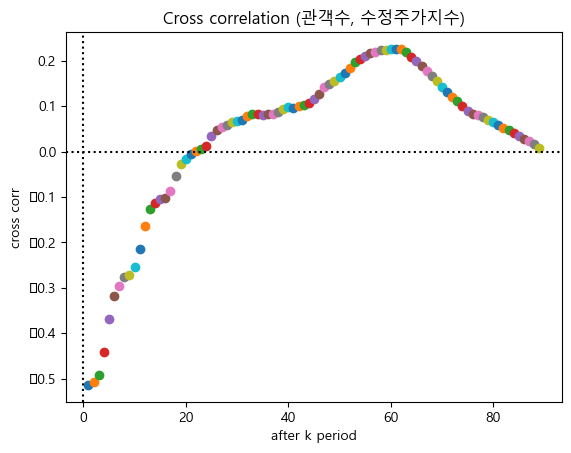

In [152]:
change(movie[2], movie_index)

### 투자시점 11일 기준 6일이상 공휴일인 영화 드랍

In [153]:
def drop_movie(df, kosdaq):
    df = df.iloc[0:11]
    # 영화데이터 날짜 컬럼 시계열로 변경
    df['날짜']= pd.to_datetime(df['날짜'])
    # 개별 영화 데이터에서 날짜와 관객수 추출
    df = df[['날짜','관객수']]
    # 인덱스 초기화
    df.reset_index(drop=True,inplace=True)

    # 코스닥 주식 Date컬럼 시계열로 변경
    kosdaq['일자'] = pd.to_datetime(kosdaq['일자'])
    # 코스닥 데이터 중 'Date', 'Open' 컬럼만 추출
    kosdaq = kosdaq[['일자', '수정주가지수']]
    # 컬럼명 변경
    kosdaq.columns = ['날짜', '수정주가지수']

    # 개별영화 + 코스닥 주식 컬럼 결합 ( a 함수를 사용하여 개별영화의 날짜(개봉일)를 기준으로 결합 )
    a = pd.merge(df, kosdaq, how='left', on='날짜')
    ls = []
    if a['수정주가지수'].isna().sum() > 6:
        ls.append(1)
    else:
        ls.append(2) 
    result = ls
    return result

In [154]:
movie_index[(movie_index['일자'] >= "2017-12-19")].head(10)

,일자,수정주가지수
0,2019-12-30,284.909520
1,2019-12-27,281.475255
2,2019-12-26,277.548066
3,2019-12-24,275.803342
4,2019-12-23,279.196411
5,2019-12-20,278.920880
6,2019-12-19,280.477313
7,2019-12-18,280.239610
8,2019-12-17,282.456555
9,2019-12-16,281.504906


In [155]:
ls2 = []

# drop_movie(movie[2], kosdaq)
for i in movie:
    x = drop_movie(i, movie_index)
    ls2.append(x)

ls2 = pd.DataFrame(ls2)
ls2[ls2[0] == 1]

,0
49,1
89,1
95,1


### 상관계수가 변하는 지점을 구하는 함수

In [156]:
# 코스닥지수와 비교
def change_CC(df, kosdaq):
    # 영화데이터 날짜 컬럼 시계열로 변경
    df['날짜']= pd.to_datetime(df['날짜'])
    # 개별 영화 데이터에서 날짜와 관객수 추출
    df = df[['날짜','관객수']]
    # 인덱스 초기화
    df.reset_index(drop=True,inplace=True)

    # 코스닥 주식 Date컬럼 시계열로 변경
    kosdaq['일자'] = pd.to_datetime(kosdaq['일자'])
    # 코스닥 데이터 중 'Date', 'Open' 컬럼만 추출
    kosdaq = kosdaq[['일자', '수정주가지수']]
    # 컬럼명 변경
    kosdaq.columns = ['날짜', '수정주가지수']

    # 개별영화 + 코스닥 주식 컬럼 결합 ( a 함수를 사용하여 개별영화의 날짜(개봉일)를 기준으로 결합 )
    a = pd.merge(df, kosdaq, how='left', on='날짜')
    # 결측치 = 선형 보간 ( interpolate() )
    a['수정주가지수'] = a['수정주가지수'].interpolate()
    # a = a.dropna()
    a = a.reset_index(drop='index')
    # a['시가 변화율'] = (a['시가'].pct_change().dropna()) * 100
    # a['누적관객수 변화율'] = (a['누적관객수'].pct_change().dropna()) * 100
    a.fillna(0, inplace=True) # 결측치 0으로 대체

    a = a.set_index('날짜')

    ## 여기서부터 시차상관계수 코드

    df1 = np.array(a[['관객수']])
    df2 = np.array(a[['수정주가지수']])

    cc = sm.tsa.stattools.ccf(df1, df2, adjusted=False, fft=True)

    sign_change_points = []
    for i in range(1, len(cc)):
        if (cc[i-1] > 0 and cc[i] < 0) or (cc[i-1] < 0 and cc[i] > 0):
            sign_change_points.append(i)
    result = sign_change_points
    return result

In [157]:
change_points = []

for i in range(100):
   x = change_CC(movie[i], movie_index)
   change_points.append(x)

df_change = pd.DataFrame(change_points)

In [158]:
def outliers_ipr(df, col):
    ## 1사분위수, 3사분위수 변수에 대입
    quartile_1, quartile_3 = np.percentile(df[col], [25, 75]) # np.percentile은 영상의 intensity 중 분위수를 구해주는 함수
    ## iqr 값을 대입
    iqr = quartile_3 - quartile_1
    ## 하단 경계 값, 상단 경계 값
    lower_whis = quartile_1 - (1.5 * iqr)
    upper_whis = quartile_3 + (1.5 * iqr)
    print(lower_whis, upper_whis)
    ## 데이터프레임에서 상단 경계보다 크거나 하단의 경계보다 작은 데이터를 출력
    outliers = df[(df[col] > upper_whis) | (df[col] < lower_whis)]
    return outliers[[col]]

In [159]:
a = outliers_ipr(df_change, 0)

drop_outliers = df_change.drop(a.index)
drop_outliers
# df_change.drop()

-13.375 51.625


,0,1,2,3,4,5,6
0,17,NaN,NaN,NaN,NaN,NaN,NaN
1,33,NaN,NaN,NaN,NaN,NaN,NaN
2,22,NaN,NaN,NaN,NaN,NaN,NaN
3,47,NaN,NaN,NaN,NaN,NaN,NaN
4,19,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
95,45,NaN,NaN,NaN,NaN,NaN,NaN
96,7,8.0,14.0,74.0,81.0,NaN,NaN
97,3,4.0,48.0,70.0,NaN,NaN,NaN
98,19,NaN,NaN,NaN,NaN,NaN,NaN


In [160]:
from scipy.stats import gmean
df_change_ls = []

df_change_ls = drop_outliers[0]
gmean(list(df_change_ls))

14.997417136390634

In [161]:
df_change[0].sort_values(ascending=False).head(20)

26    59
11    48
3     47
95    45
28    44
73    43
13    39
9     39
68    38
15    38
80    37
18    36
59    35
83    34
1     33
94    33
91    33
21    32
55    31
49    30
Name: 0, dtype: int64

## 수정종가지수 수익률과 코스닥 수익률 비교 후 타겟컬럼 생성

In [162]:
## 데이터 로드
movie_index = pd.read_csv('../csv&excel/영화업종지수.csv')
new_df = pd.read_csv('../csv&excel/전처리_2.csv')
kosdaq = pd.read_csv('../csv&excel/kosdaq.csv')

In [163]:
#코스닥 수정종가 불러오기
kosdaq = kosdaq[['Date','Adj Close' ]]
kosdaq.columns = ['일자','수정종가']
kosdaq['일자'] = pd.to_datetime(kosdaq['일자'])
kosdaq['수정주가지수15'] = kosdaq['수정종가'].shift(14)
kosdaq.columns = ['개봉일', '수정종가', '수정종가15']

## 영화업종지수 일자 시계열데이터로 변경, 수정주가지수, 15일 뒤 주가지수 컬럼 생성
movie_index['일자'] = pd.to_datetime(movie_index['일자'])
movie_index['수정주가지수15'] = movie_index['수정주가지수'].shift(14)
movie_index.columns = ['개봉일', '수정주가지수', '수정주가지수15']

In [164]:
# 049범죄도시, 089킹스맨, 095조선명탐정
# movie[95]
new_df = new_df.drop(new_df.index[49], axis=0)
new_df = new_df.drop(new_df.index[89], axis=0)
new_df = new_df.drop(new_df.index[95], axis=0)

In [165]:
## 개봉일 기준 주가지수, 수정주가지수 merge, 결측치(주말, 공휴일 등) interpolate 처리
new_df['개봉일'] = pd.to_datetime(new_df['개봉일'])
new_df = new_df.reset_index(drop='index')
new_df = pd.merge(new_df, movie_index, how='left', on='개봉일')
new_df['수정주가지수'] = new_df['수정주가지수'].interpolate()
new_df['수정주가지수15'] = new_df['수정주가지수15'].interpolate()
## 일자 시계열데이터로 변경, 수정종가, 12일 뒤 주가지수 컬럼 생성
new_df['개봉일'] = pd.to_datetime(new_df['개봉일'])
new_df = new_df.reset_index(drop='index')
new_df = pd.merge(new_df, kosdaq, how='left', on='개봉일')
new_df['수정종가'] = new_df['수정종가'].interpolate()
new_df['수정종가15'] = new_df['수정종가15'].interpolate()
## 수익률 컬럼 생성
# 수정주가 15일 수익률 컬럼 생성
new_df['15수정주가지수'] = (new_df['수정주가지수15'] - new_df['수정주가지수']) / new_df['수정주가지수']
# 코스닥 15일 수익률 컬럼 생성
new_df['15수정종가'] = (new_df['수정종가15'] - new_df['수정종가']) / new_df['수정종가']

In [166]:
#타겟 컬럼 생성
new_df['타겟'] = 0

for i in range(len(new_df)):
    if new_df['15수정주가지수'][i] > new_df['15수정종가'][i]:
        new_df['타겟'][i] = 1

In [167]:
new_df.columns

Index(['영화명', '개봉일', '국적', '전국스크린수', '전국매출액', '전국관객수', '서울매출액', '서울관객수', '장르',
       '등급', '개봉연도', '평균 제작비', '영화구분', '수정전국매출액', '국내배급사', '상장배급사', '주요배급사',
       '개봉일관객수', '개봉일매출액', '개봉일매출비율', '배우가중치', '감독가중치', '수정주가지수', '수정주가지수15',
       '수정종가', '수정종가15', '15수정주가지수', '15수정종가', '타겟'],
      dtype='object')

In [168]:
new_df = new_df[['영화명', '개봉일', '국적', '전국스크린수', '전국매출액', '전국관객수', '서울매출액', '서울관객수', '장르',
       '등급', '개봉연도', '평균 제작비', '영화구분', '수정전국매출액', '국내배급사', '상장배급사', '주요배급사', '개봉일관객수',
       '개봉일매출액', '개봉일매출비율', '배우가중치', '감독가중치', '타겟']]
new_df

,영화명,개봉일,국적,전국스크린수,전국매출액,전국관객수,서울매출액,서울관객수,장르,등급,...,수정전국매출액,국내배급사,상장배급사,주요배급사,개봉일관객수,개봉일매출액,개봉일매출비율,배우가중치,감독가중치,타겟
0,명량,2014-07-30,1.0,1587,135748398910,17613682,3.312123e+10,4163666,사극,1,...,1357.483989,0.0,1.0,1,682701.0,4.708879e+09,61.6,39.000000,2.000000,0
1,극한직업,2019-01-23,1.0,1978,139647979516,16264944,3.185866e+10,3638287,코미디,1,...,1396.479795,0.0,1.0,1,368582.0,3.004763e+09,73.2,21.000000,3.000000,1
2,신과함께-죄와 벌,2017-12-20,1.0,1912,115698654137,14410754,2.753083e+10,3346172,판타지,2,...,1156.986541,0.0,1.0,1,406365.0,2.984151e+09,63.2,27.000000,3.000000,0
3,국제시장,2014-12-17,1.0,966,110828014630,14245998,2.584252e+10,3233946,드라마,2,...,1108.280146,0.0,1.0,1,184756.0,1.356870e+09,31.0,29.000000,1.000000,0
4,어벤져스: 엔드게임,2019-04-24,0.0,2835,122182694160,13934592,3.357714e+10,3597963,액션,2,...,1221.826942,1.0,0.0,1,1338729.0,9.678990e+09,97.1,22.000000,3.000000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
906,스파이 브릿지,2015-11-05,0.0,425,2015360478,260721,7.222464e+08,90018,스릴러,2,...,20.153605,1.0,0.0,1,18404.0,1.352783e+08,5.6,0.333333,0.100000,1
907,함정,2015-09-10,1.0,445,2088685200,257716,4.114176e+08,50477,스릴러,0,...,20.886852,0.0,0.0,0,32277.0,2.502558e+08,13.1,0.633333,0.033333,1
908,파이널 데스티네이션5,2011-09-08,0.0,168,2370348500,257193,8.800060e+08,87499,공포(호러),0,...,23.703485,1.0,0.0,1,12613.0,1.180325e+08,7.5,0.033333,0.066667,1
909,언브로큰,2015-01-07,0.0,401,1997947292,256475,6.057764e+08,75489,액션,1,...,19.979473,1.0,0.0,1,26707.0,1.993983e+08,5.8,0.233333,0.033333,0


In [169]:
new_df.to_csv('../csv&excel/Rawdata.csv', index=0)